In [0]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn import preprocessing # ADDED TO STANDARDIZE DATA


# Funneled

In [0]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape


In [0]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

## Disabled PCA with Standardized Data

### Standardization of the data

In [0]:
X_scaled = preprocessing.scale(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


### Before Adding the specified addition values for C

In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()

# ADDED NEEDED VALUES
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

# DISABLED PCA BY USING ORIGINAL DATA
clf = clf.fit(X_scaled, y_train)
print("done in %0.3fs" % (time() - t0))
print("The score of the best estimator found by grid search =", clf.best_score_)
print("With corresponding C value of", clf.best_estimator_.C)


Fitting the classifier to the training set


NameError: ignored

### After Adding the specified addition values for C

In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()

# ADDED NEEDED VALUES
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1e0, 1e1, 1e2],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

# DISABLED PCA BY USING ORIGINAL DATA
clf = clf.fit(X_scaled, y_train)
print("done in %0.3fs" % (time() - t0))
print("The score of the best estimator found by grid search =", clf.best_score_)
print("With corresponding C value of", clf.best_estimator_.C)
#print(clf.best_estimator_)

Fitting the classifier to the training set
done in 952.349s
The score of the best estimator found by grid search = 0.8354037267080745
With corresponding C value of 1000.0


### Report the best classifier found by the grid search and its performance. Comment on the value of C compared to the best value provided in the tutorial. Justify the difference.

Before adding the C values specified in the project, the best performance achieved on standardized data by the classifier had C = 1e3. After adding the specified values the best performance achieved was also using the same value which is C = 1e3. This is due to that this value is realtively large that if fits a large dataset without extracted features so a high percentage of data points will be misclassified and it will decrease performance of SVM. It is also not the largest value in the grid search because larger values will not allow any kind of misclassifications at all.

## Enabled PCA with grid search for number of components

In [0]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components_list = [50, 150, 190, 300, 1000]
scores = []
c_values = []
PCAs = []
models = []
best = 0
bestIdx = 0
for i in range(5):

  n_components = n_components_list[i]

  print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
  t0 = time()
  pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
  PCAs.append(pca)
  print("done in %0.3fs" % (time() - t0))
  print("Projecting the input data on the eigenfaces orthonormal basis")

  t0 = time()
  X_train_pca = pca.transform(X_train)
  print("done in %0.3fs" % (time() - t0))

  # Train a SVM classification model

  print("Fitting the classifier to the training set")
  t0 = time()

  # ADDED NEEDED VALUES
  param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1, 10, 100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
  clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

  # DISABLED PCA BY USING ORIGINAL DATA
  clf = clf.fit(X_train_pca, y_train)
  models.append(clf)
  print("done in %0.3fs" % (time() - t0))
  if(clf.best_score_ > best):
    best = clf.best_score_
    bestIdx = i
    
  scores.append(clf.best_score_)
  c_values.append(clf.best_estimator_.C)
  print("The score of the best estimator found by grid search =", clf.best_score_)
  print("With corresponding C value of", clf.best_estimator_.C)
  print("Number of components =", n_components)

Extracting the top 50 eigenfaces from 966 faces
done in 0.254s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.008s
Fitting the classifier to the training set
done in 33.775s
The score of the best estimator found by grid search = 0.8343685300207039
With corresponding C value of 10
Number of components = 50
Extracting the top 150 eigenfaces from 966 faces
done in 0.348s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.029s
Fitting the classifier to the training set
done in 94.834s
The score of the best estimator found by grid search = 0.8333333333333334
With corresponding C value of 10
Number of components = 150
Extracting the top 190 eigenfaces from 966 faces
done in 0.498s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.071s
Fitting the classifier to the training set
done in 117.045s
The score of the best estimator found by grid search = 0.8022774327122153
With corresponding C value of 10
Number of components = 190

## Plotting

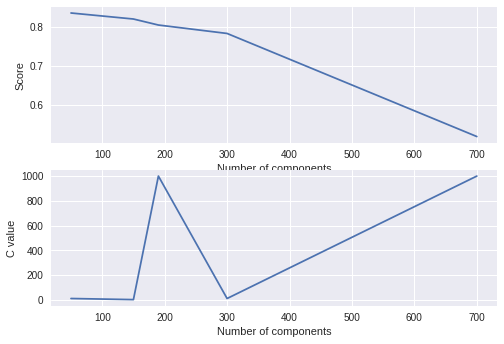

In [0]:
plt.subplot(211)
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.plot(n_components_list, scores)
plt.subplot(212)
plt.xlabel('Number of components')
plt.ylabel('C value')
plt.plot(n_components_list, c_values)
plt.show()

## Quantitative evaluation of the model quality on the test set


In [0]:
X_test_pca = PCAs[bestIdx].transform(X_test)
print("Predicting people's names on the test set")
t0 = time()
y_pred = models[bestIdx].predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

## Plotting Original faces vs Eigenfaces

In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [0]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

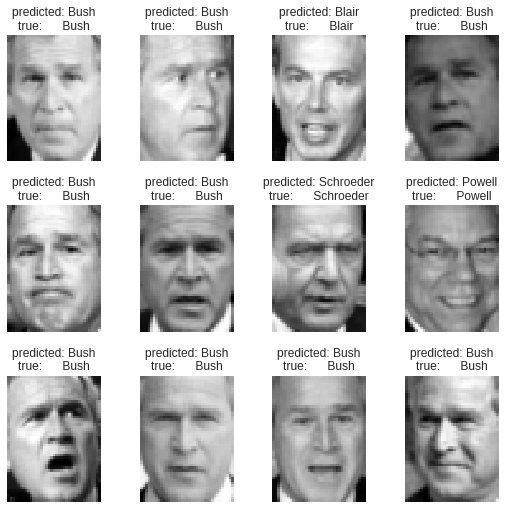

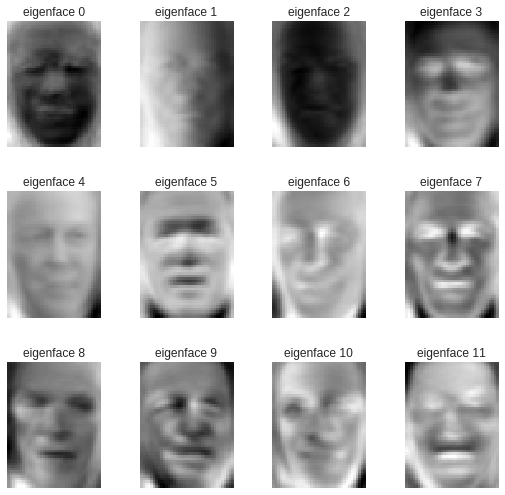

In [0]:
eigenfaces = PCAs[bestIdx].components_.reshape((n_components_list[bestIdx], h, w))

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

### Report on the change in performance you observe. What causes the performance to change with respect to the number of principal components in this particular manner?

The minimum number of components which is 50 components resulted in the best performance (0.83), after that the performance decreased as we increase the number of components until it reached 0.4. This behavior was odd because the performance should have improved when adding more components because it means more information from original input, however, since the SVMs are designed to handle smaller datasets better, the small number of components was a good fit for it.
We can observe too that the C value for the SVM is now 1 or 10 for small number of components, this is due to that the eigenfaces (or the eigen vectors) are now compatible with the dataset so there will not be a lot of misclassifications when the C value is small.

# Unfunneled

In [0]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, funneled = False, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape


Automatically created module for IPython interactive environment


In [0]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

## Disabled PCA with Standardized Data

### Standardization of the data

In [0]:
X_scaled = preprocessing.scale(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()

# ADDED NEEDED VALUES
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1e0, 1e1, 1e2],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

# DISABLED PCA BY USING ORIGINAL DATA
clf = clf.fit(X_scaled, y_train)
print("done in %0.3fs" % (time() - t0))
print("The score of the best estimator found by grid search =", clf.best_score_)
print("With corresponding C value of", clf.best_estimator_.C)
#print(clf.best_estimator_)

Fitting the classifier to the training set
done in 989.243s
The score of the best estimator found by grid search = 0.8043478260869565
With corresponding C value of 1000.0


## Enabled PCA with grid search for number of components

In [0]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components_list = [50, 150, 190, 300, 1000]
scores = []
c_values = []
PCAs = []
models = []
best = 0
bestIdx = 0
for i in range(5):

  n_components = n_components_list[i]

  print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
  t0 = time()
  pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
  PCAs.append(pca)
  print("done in %0.3fs" % (time() - t0))
  print("Projecting the input data on the eigenfaces orthonormal basis")

  t0 = time()
  X_train_pca = pca.transform(X_train)
  print("done in %0.3fs" % (time() - t0))

  # Train a SVM classification model

  print("Fitting the classifier to the training set")
  t0 = time()

  # ADDED NEEDED VALUES
  param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5, 1, 10, 100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
  clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

  # DISABLED PCA BY USING ORIGINAL DATA
  clf = clf.fit(X_train_pca, y_train)
  models.append(clf)
  print("done in %0.3fs" % (time() - t0))
  if(clf.best_score_ > best):
    best = clf.best_score_
    bestIdx = i
    
  scores.append(clf.best_score_)
  c_values.append(clf.best_estimator_.C)
  print("The score of the best estimator found by grid search =", clf.best_score_)
  print("With corresponding C value of", clf.best_estimator_.C)
  print("Number of components =", n_components)

Extracting the top 50 eigenfaces from 966 faces
done in 0.249s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
Fitting the classifier to the training set


### Report the change in performance.
A loss in performance -from 0.85 to 0.80- was encountered after changing the dataset from the funneled to the unfunneled. The unfunneled images have some unimportant information that is not related to the face itself and considered as noise. This noise affects the performance of the classifier and decreases it, funneling fixes this problem and removes the unneeded information in the image. More about funneling is mentioned in the comparison part.

## Plotting

NameError: ignored

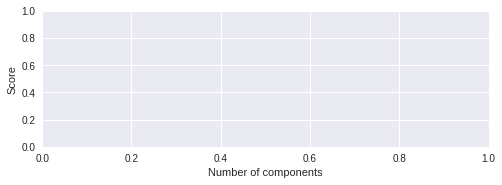

In [0]:
plt.subplot(211)
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.plot(n_components_list, scores)
plt.subplot(212)
plt.xlabel('Number of components')
plt.ylabel('C value')
plt.plot(n_components_list, c_values)
plt.show()

## Quantitative evaluation of the model quality on the test set


In [0]:
X_test_pca = PCAs[bestIdx].transform(X_test)
print("Predicting people's names on the test set")
t0 = time()
y_pred = models[bestIdx].predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.088s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.54      0.70        13
     Colin Powell       0.91      0.83      0.87        60
  Donald Rumsfeld       0.78      0.78      0.78        27
    George W Bush       0.85      0.90      0.88       146
Gerhard Schroeder       0.68      0.76      0.72        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.66      0.69      0.68        36

      avg / total       0.82      0.82      0.82       322

[[  7   1   2   2   0   0   1]
 [  0  50   1   5   1   1   2]
 [  0   0  21   1   2   0   3]
 [  0   2   2 132   3   0   7]
 [  0   0   1   4  19   1   0]
 [  0   1   0   4   1   9   0]
 [  0   1   0   7   2   1  25]]


## Plotting Original faces vs Eigenfaces

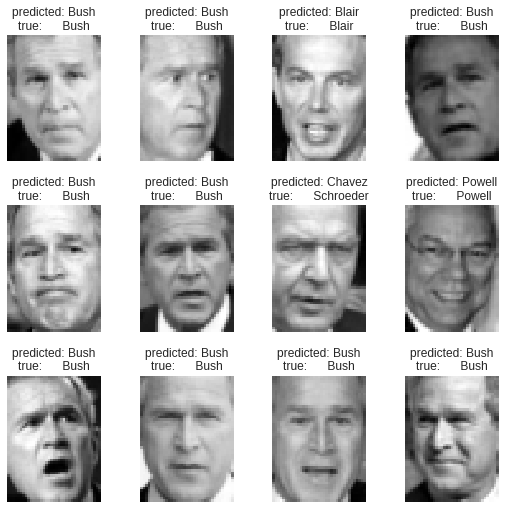

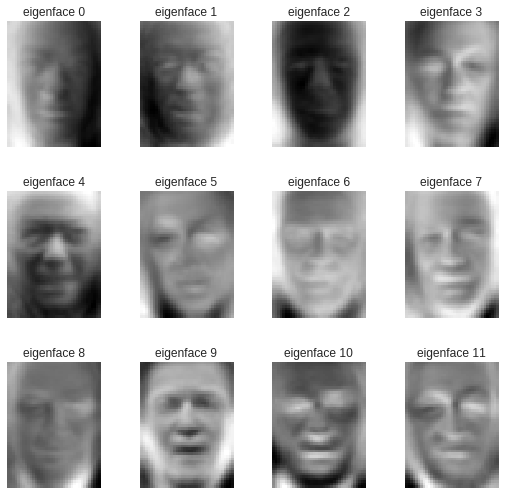

In [0]:
eigenfaces = PCAs[bestIdx].components_.reshape((n_components_list[bestIdx], h, w))

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

### Compare the Eigenfaces plotted in the last part of the tutorial for both the ‘funneled’ and ‘unfunneled’ datasets.

Funneling is considered as an image processing step. It's summed up as a method of alignment in terms of rotation and translation. It can also refer to the removal of other forms of non-spatial variability, like brightness transformations, that make a set of images different. We find that the unfunneled dataset in its normal and Eigen faces has a problem in alignment and some faces is not totally centered and symmetric and some of them is rotated for inside.
For example, we notice that there is an eye that is -lower- than an eye in unfunneled eigenface 5 which isn' t the case in any funneled eigenface. Also the unfunneled eigenface 7 has this empty part in the left side but no emptiness on the right. This emptiness is not part of the face and the face is rotated for inside a little bit. Those problems aren't present so clearly in the funneled dataset because funneling fixes them.

# CPU, GPU and TPU runtime

In [0]:
n_components = 50

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
total_time = time() - t0
print("Extracting done in %0.3fs using TPU" % (time() - t0))
print("Projecting the input data on the eigenfaces orthonormal basis")

t0 = time()
X_train_pca = pca.transform(X_train)

total_time += time() - t0
print("Transformation done in %0.3fs using TPU" % (time() - t0))

  # Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()

# ADDED NEEDED VALUES
param_grid = {'C': [10],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

# DISABLED PCA BY USING ORIGINAL DATA
clf = clf.fit(X_train_pca, y_train)
total_time += time() - t0
print("Fitting done in %0.3fs  using TPU" % (time() - t0))    
print("The score of the best estimator found by grid search =", clf.best_score_)
print("With corresponding C value of", clf.best_estimator_.C)
print("Number of components =", n_components)

print("Total time using TPU =", total_time)

Extracting the top 50 eigenfaces from 966 faces
Extracting done in 0.318s using TPU
Projecting the input data on the eigenfaces orthonormal basis
Transformation done in 0.014s using TPU
Fitting the classifier to the training set
Fitting done in 5.574s  using TPU
The score of the best estimator found by grid search = 0.8343685300207039
With corresponding C value of 10
Number of components = 50
Total time using TPU = 5.906120300292969


### Run this classifier using the CPU runtime, the GPU runtime and the TPU runtime. Report the observed speedup if any.
The best classifier configurations were: 50 components for the PCA and C = 10 for the SVM. Those configuration gave 0.836 score.

CPU runtime took 6 seconds to do PCA and train the SVM with 50 components and C = 10

GPU runtime took 5 seconds to do PCA and train the SVM with 50 components and C = 10

TPU runtime took 5.9 seconds to do PCA and train the SVM with 50 components and C = 10 which is near the performance of the CPU but  alittle bit better.

We can observe that the best speedup in training was using the GPU because of its huge computational power and resources over the normal CPU. The TPU is supposed to have good computational power too and it is created to help in training models and Machine Learning tasks but it's designed to work with TensorFlow programs, so scikit learn libraries will not have a much better performance on the TPU.
